In [1]:
# read j3 wrf ts files

import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils_solar import Tower
from mmctools.helper_functions import calc_wind, power_spectral_density, calc_spectra
from dateutil import parser
import datetime
from mmctools.plotting import TaylorDiagram, plot_spectrum
import matplotlib.colors as mcolors
import re
from netCDF4 import Dataset
import wrf

obs_dir = '/projects/mmcpnnl/sgp_obs/'
wrf_runs_dir = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'
nb_dir = !pwd

# time step of wrf runs
d02_wrf_dt = 10
d03_wrf_dt = 2
d04_wrf_dt = 0.4

# run nickname, tower name & domain, time step, spin up time in hour
sim_dict = {'meso': ['c1.d02', d02_wrf_dt, np.timedelta64(12, 'h')], 
            'les200m': ['c1.d03', d03_wrf_dt, np.timedelta64(2, 'h')], 
            'les40m': ['c1.d04', d04_wrf_dt, np.timedelta64(1, 'h')]}

# turbulence averaging interval in minutes
avg_interval = 10

# derive spectra every x duration
spectra_window = '10min'
# average all the spectra every y duration
spectra_avg_freq = '1h'
spectra_avg_time = np.timedelta64(int(re.findall('\d+', spectra_avg_freq)[0]), 
                                  re.findall('[a-z]+', spectra_avg_freq)[0])

# les_spinup = np.timedelta64(1, 'h')

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

runs_list = list(data_dir_df.index)[:-1]

In [2]:
eval_date = '2018-08-05'
site_latitude  = 36.6050
site_longitude = -97.485

date_col = data_dir_df[eval_date]

# the runs use the same vertical levels
file = wrf_runs_dir+date_col['mynn']+'/wrfout_d04_'+eval_date+'_20:00:00'

wrf_single = Dataset(file, 'r')

site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)

hgt = wrf.getvar(wrf_single, 'height_agl')

hgt_1pt = hgt[:, site_loc_ij.values[1], site_loc_ij.values[0]]

wrf_height_levs = list(hgt_1pt.values)[:70]

In [84]:
def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=wrf_height_levs, 
                         height_var='ph', agl=True)

    return ds

def get_prime(ds, dt, var):
    
    avg_seconds = avg_interval*60
    
    ds[var+'_prime'] = ds[var] - ds[var].rolling(datetime=int(avg_seconds/dt), center=True).mean()
    
    return ds

def read_1wrf_ts(eval_date, sim, run):
    
    col = data_dir_df[eval_date]
    sim_val = sim_dict[sim]

    # # simulation start time
    wrf_start = col['wrf_start']
    
    wrf_file_path = wrf_runs_dir+col[run]+'/z_ts/z.'+sim_val[0]
    wrf_tower = Tower(wrf_file_path)

    wrf_ds = read_tower_to_ds(wrf_tower, wrf_start, sim_val[1])
    wrf_ds['wspd'], wrf_ds['wdir'] = calc_wind(wrf_ds)
    
    wrf_ds = get_prime(wrf_ds, sim_val[1], 'u')
    wrf_ds = get_prime(wrf_ds, sim_val[1], 'v')
    wrf_ds = get_prime(wrf_ds, sim_val[1], 'w')
    
    return wrf_ds

def get_wsshear_ds(ds):
    
    top = ds.isel(height=np.arange(1, len(ds.height), 1))['wspd'].values
    bot = ds.isel(height=np.arange(0, len(ds.height)-1, 1))['wspd'].values
    
    shear = (top-bot).squeeze()

    out_ds = xr.DataArray(shear, coords=[ds.datetime, ds.height[1:]], dims=['datetime', 'height'])
    
    return out_ds

def get_tke_da(ds): 
    
    tke = ((ds['u']).resample(datetime=str(avg_interval)+'min').var()\
           +(ds['v']).resample(datetime=str(avg_interval)+'min').var()\
           +(ds['w']).resample(datetime=str(avg_interval)+'min').var())/2
    
    return tke

In [85]:
eval_date = '2018-08-05'
sim = 'meso'
run = 'mynn'

wrf_meso_ds = read_1wrf_ts(eval_date, 'meso', run)
wrf_les200_ds = read_1wrf_ts(eval_date, 'les200m', run)
wrf_les40_ds = read_1wrf_ts(eval_date, 'les40m', run)

In [86]:
time_start = wrf_les40_ds['datetime'].min().values + sim_dict['les40m'][2]
time_end = wrf_les40_ds['datetime'].max().values

wrf_meso_ds = wrf_meso_ds.sel(datetime=slice(time_start, time_end))
wrf_les200_ds = wrf_les200_ds.sel(datetime=slice(time_start, time_end))
wrf_les40_ds = wrf_les40_ds.sel(datetime=slice(time_start, time_end))

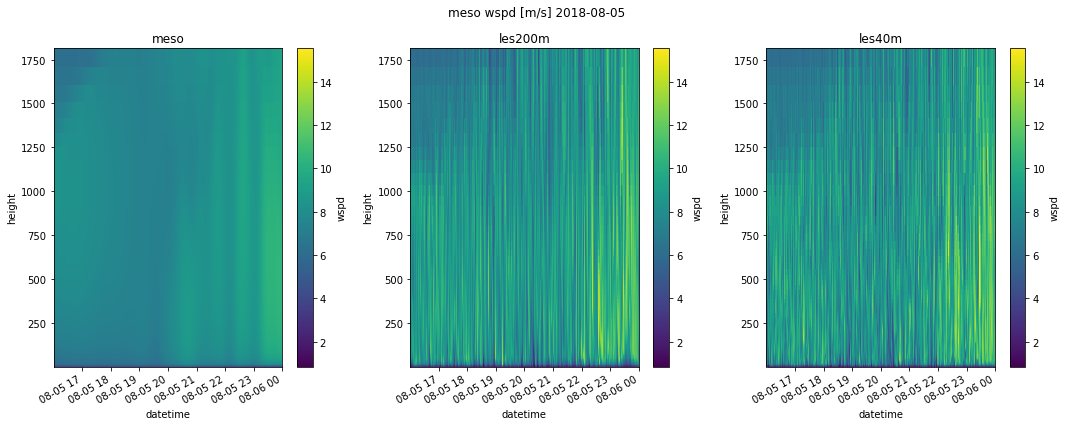

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

v_min = np.min([wrf_meso_ds['wspd'].min(), wrf_les200_ds['wspd'].min(), wrf_les40_ds['wspd'].min()])
v_max = np.max([wrf_meso_ds['wspd'].max(), wrf_les200_ds['wspd'].max(), wrf_les40_ds['wspd'].max()])

wrf_meso_ds['wspd'].T.plot(ax=axs[0], vmin=v_min, vmax=v_max)
axs[0].set_title('meso')

wrf_les200_ds['wspd'].T.plot(ax=axs[1], vmin=v_min, vmax=v_max)
axs[1].set_title('les200m')

wrf_les40_ds['wspd'].T.plot(ax=axs[2], vmin=v_min, vmax=v_max)
axs[2].set_title('les40m')

plt.suptitle(sim+' '+'wspd'+' [m/s] '+eval_date)

plt.tight_layout()
plt.show()

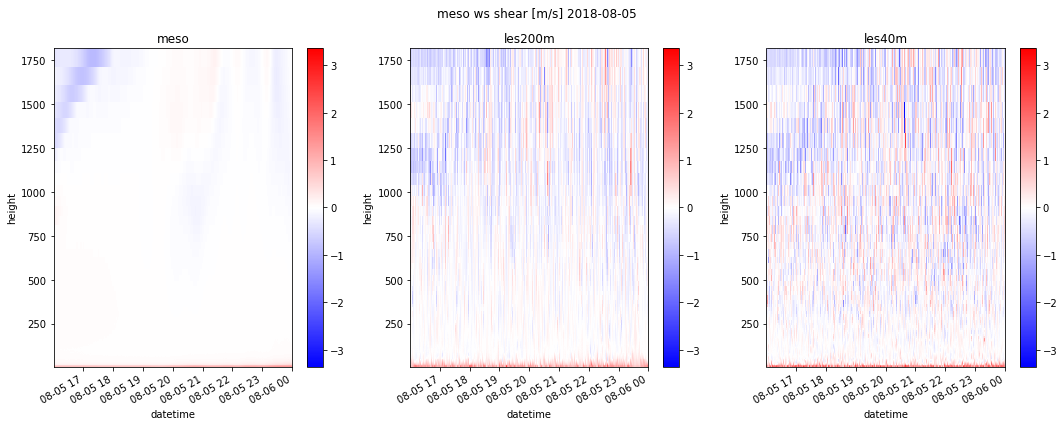

In [15]:
meso_shear = get_wsshear_ds(wrf_meso_ds)
les200_shear = get_wsshear_ds(wrf_les200_ds)
les40_shear = get_wsshear_ds(wrf_les40_ds)

fig, axs = plt.subplots(1, 3, figsize=(15, 6))

v_min = np.min([meso_shear.min(), les200_shear.min(), les40_shear.min()])
v_max = np.max([meso_shear.max(), les200_shear.max(), les40_shear.max()])

v_diff = np.max([abs(v_min), abs(v_max)])

meso_shear.T.plot(ax=axs[0], vmin=-v_diff, vmax=v_diff, cmap='bwr')
axs[0].set_title('meso')

les200_shear.T.plot(ax=axs[1], vmin=-v_diff, vmax=v_diff, cmap='bwr')
axs[1].set_title('les200m')

les40_shear.T.plot(ax=axs[2], vmin=-v_diff, vmax=v_diff, cmap='bwr')
axs[2].set_title('les40m')

plt.suptitle(sim+' '+'ws shear'+' [m/s] '+eval_date)

plt.tight_layout()
plt.show()

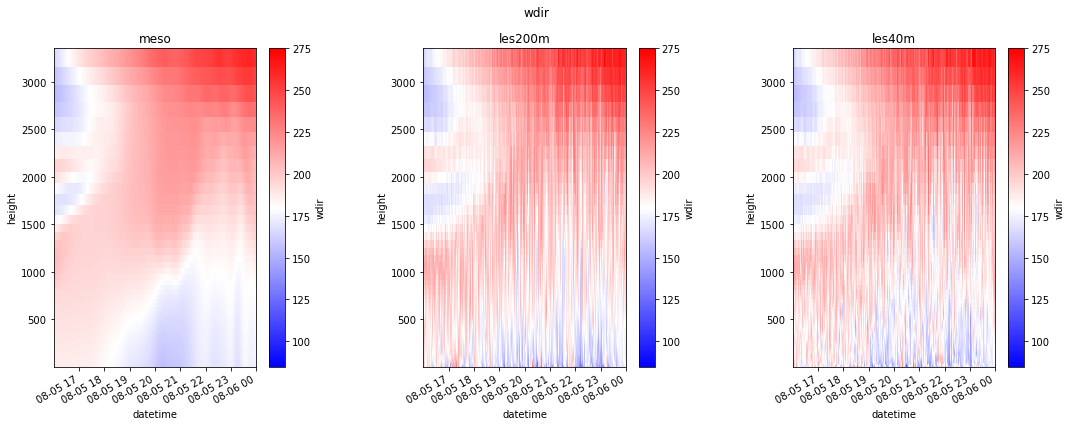

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

v_min = np.min([wrf_meso_ds['wdir'].min(), wrf_les200_ds['wdir'].min(), wrf_les40_ds['wdir'].min()])
v_max = np.max([wrf_meso_ds['wdir'].max(), wrf_les200_ds['wdir'].max(), wrf_les40_ds['wdir'].max()])

v_diff = np.max([180-v_min, v_max-180])

ax0 = wrf_meso_ds['wdir'].T.plot(ax=axs[0], vmin=180-v_diff, vmax=180+v_diff, cmap='bwr')
axs[0].set_title('meso')
# cb = ax0.colorbar()
# cb.remove()

ax1 = wrf_les200_ds['wdir'].T.plot(ax=axs[1], vmin=180-v_diff, vmax=180+v_diff, cmap='bwr')
axs[1].set_title('les200m')

ax2 = wrf_les40_ds['wdir'].T.plot(ax=axs[2], vmin=180-v_diff, vmax=180+v_diff, cmap='bwr')
axs[2].set_title('les40m')

plt.suptitle('wdir [deg]')

plt.tight_layout(w_pad=5)
plt.show()

In [87]:
tke = ((wrf_meso_ds['u']).resample(datetime=str(avg_interval)+'min').var()\
+(wrf_meso_ds['v']).resample(datetime=str(avg_interval)+'min').var()\
+(wrf_meso_ds['w']).resample(datetime=str(avg_interval)+'min').var())/2

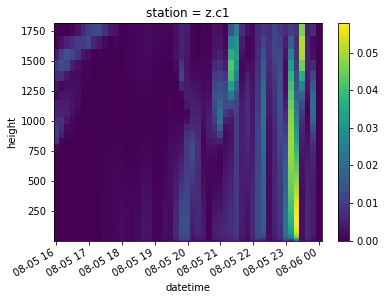

In [88]:
tke.T.plot()

In [94]:
prime2_tke = ((wrf_meso_ds['u_prime']**2).rolling(datetime='10Min', center=True).mean()
# +(wrf_meso_ds['v_prime']**2).resample(datetime='10Min').mean()\
# +(wrf_meso_ds['w_prime']**2).resample(datetime='10Min').mean())/2

SyntaxError: unexpected EOF while parsing (<ipython-input-94-ee2ad9343271>, line 3)

In [89]:
prime_tke = ((wrf_meso_ds['u_prime']**2).resample(datetime='10Min').mean()\
+(wrf_meso_ds['v_prime']**2).resample(datetime='10Min').mean()\
+(wrf_meso_ds['w_prime']**2).resample(datetime='10Min').mean())/2

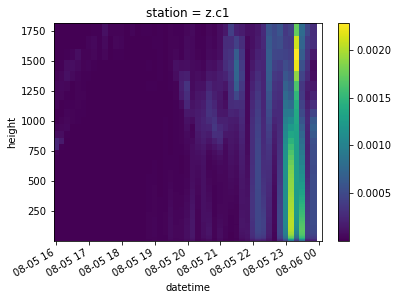

In [90]:
prime_tke.T.plot()

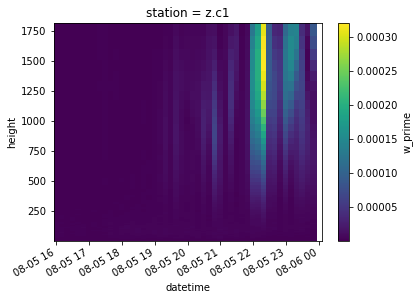

In [32]:
(wrf_meso_ds['w_prime']**2).resample(datetime='10Min').mean().T.plot()

In [93]:
3600/d02_wrf_dt

360.0

In [101]:
list(wrf_meso_ds['u'].rolling(datetime=int(600/d02_wrf_dt), center=True).mean().isel(height=1).values)

[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([0.5881839]),
 array([0.58831409]),
 array([0.58844252]),
 array([0.58856043]),
 array([0.58868229]),
 array([0.58879236]),
 array([0.58891093]),
 array([0.58899485]),
 array([0.5890845]),
 array([0.58917269]),
 array([0.58924923]),
 array([0.58933747]),
 array([0.58943673]),
 array([0.5895543]),
 array([0.58965689]),
 array([0.58977433]),
 array([0.58990023]),
 array([0.59002646]),
 array([0.59014131]),
 array([0.59027506]),
 array([0.59040775]),
 array([0.59053646]),
 array([0.59065559]),
 array([0.59078166]),
 array([0.59091152]),
 ar

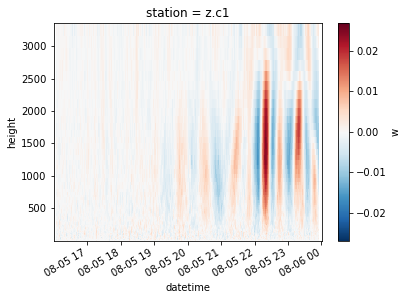

In [108]:
avg_seconds = avg_interval*60

wrf_meso_ds['w_prime'] = wrf_meso_ds['w'] - wrf_meso_ds['w'].rolling(datetime=int(avg_seconds/sim_val[1]), center=True).mean()

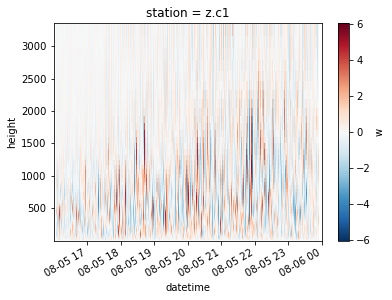

In [109]:
(wrf_les40_ds['w'] - wrf_les40_ds['w'].rolling(datetime=int(600/d04_wrf_dt), center=True).mean()).T.plot()

In [71]:
from mmctools.helper_functions import model4D_calcQOIs

In [82]:
model4D_calcQOIs(wrf_meso_ds, 'datetime', data_type='ts', mean_opt='lowess', lowess_delta=6000)

Calculating means... this may take a while.
calculating lowess means
u


AttributeError: 'Dataset' object has no attribute 'nz'

In [83]:
wrf_meso_ds

<xarray.Dataset>
Dimensions:      (datetime: 2880, height: 80, station: 1)
Coordinates:
  * datetime     (datetime) datetime64[ns] 2018-08-05T16:00:10 ... 2018-08-06
  * height       (height) float64 2.465 7.39 12.3 ... 3.064e+03 3.257e+03
  * station      (station) <U4 'z.c1'
Data variables:
    theta        (datetime, height, station) float64 307.7 307.2 ... 314.8 315.7
    pr           (datetime, height, station) float64 9.798e+04 ... 6.78e+04
    w            (datetime, height, station) float64 -0.008377 ... 0.09536
    u            (datetime, height, station) float64 0.475 0.5845 ... 6.783
    qv           (datetime, height, station) float64 0.01402 ... 0.005994
    v            (datetime, height, station) float64 4.064 4.877 ... 2.416 1.42
    i            (station) int64 122
    j            (station) int64 126
    lat          (station) float64 36.62
    lon          (station) float64 -97.49
    zsurface     (station) float64 306.8
    t2           (datetime, station) float64 305.8 305.8 305.8 ... 310.3 310.2
    q2           (datetime, station) float64 0.01404 0.01403 ... 0.01089 0.01089
    u10          (datetime, station) float64 0.6328 0.6341 ... -0.5749 -0.5695
    v10          (datetime, station) float64 5.252 5.255 5.255 ... 6.494 6.49
    psfc         (datetime, station) float64 9.798e+04 9.798e+04 ... 9.757e+04
    glw          (datetime, station) float64 408.4 408.4 408.4 ... 425.9 425.9
    gsw          (datetime, station) float64 620.6 620.6 620.6 ... 194.3 194.3
    hfx          (datetime, station) float64 294.0 293.9 293.9 ... 7.213 7.407
    lh           (datetime, station) float64 153.4 153.4 153.4 ... 79.04 79.04
    tsk          (datetime, station) float64 310.5 310.5 310.5 ... 310.4 310.4
    slttop       (datetime, station) float64 301.7 301.7 301.7 ... 308.8 308.8
    rainc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    rainnc       (datetime, station) float64 0.02772 0.02772 ... 0.03719 0.03719
    clw          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cldfrac2d    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wvp          (datetime, station) float64 35.96 35.96 35.97 ... 33.4 33.4
    lwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    swp          (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_sum       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    iwp_tot      (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wp_tot_sum   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qc        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi        (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qs        (datetime, station) float64 3e-05 3e-05 3e-05 ... 4e-05 4e-05
    re_qc_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    re_qi_tot    (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qc       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi       (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qs       (datetime, station) float64 1e-05 1e-05 1e-05 ... 9e-05 9e-05
    tau_qc_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tau_qi_tot   (datetime, station) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cbaseht      (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht       (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    cbaseht_tot  (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    ctopht_tot   (datetime, station) float64 -999.0 -999.0 ... -999.0 -999.0
    clrnidx      (datetime, station) float64 0.7431 0.7431 ... 0.609 0.609
    sza          (d